In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/ece657aw20asg4coronavirus/time_series_covid19_confirmed_global_1.csv
/kaggle/input/ece657aw20asg4coronavirus/time_series_covid19_confirmed_global.csv
/kaggle/input/ece657aw20asg4coronavirus/time_series_covid19_recovered_global.csv
/kaggle/input/ece657aw20asg4coronavirus/time_series_covid19_deaths_global.csv


In [4]:
df_confirmed = pd.read_csv('/kaggle/input/ece657aw20asg4coronavirus/time_series_covid19_confirmed_global.csv')

In [5]:
country = "India"
df_confirmed1 = df_confirmed[df_confirmed["Country/Region"] == country]

df_confirmed1

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20
131,NaN,India,21.0,78.0,0,0,0,0,0,0,...,5916,6725,7598,8446,9205,10453,11487,12322,13430,14352


In [6]:
df_confirmed2 = pd.DataFrame(df_confirmed1[df_confirmed1.columns[4:]].sum(),columns=["confirmed"])
df_confirmed2.index = pd.to_datetime(df_confirmed2.index,format='%m/%d/%y')
df_confirmed2

,confirmed
2020-01-22,0
2020-01-23,0
2020-01-24,0
2020-01-25,0
2020-01-26,0
...,...
2020-04-13,10453
2020-04-14,11487
2020-04-15,12322
2020-04-16,13430


,confirmed
2020-04-08,5916
2020-04-09,6725
2020-04-10,7598
2020-04-11,8446
2020-04-12,9205
2020-04-13,10453
2020-04-14,11487
2020-04-15,12322
2020-04-16,13430
2020-04-17,14352


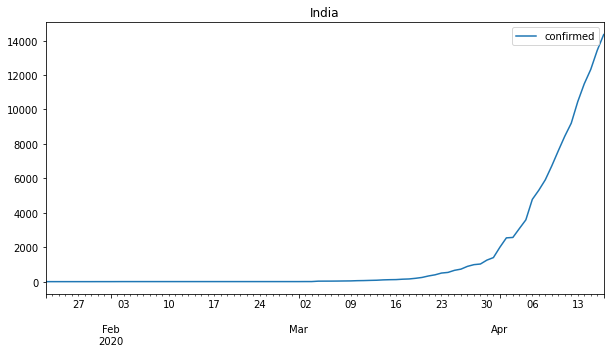

In [7]:
df_confirmed2.plot(figsize=(10,5),title="India")
df_new = df_confirmed2[["confirmed"]]
df_new.tail(10)

In [8]:
len(df_new)
x = len(df_new) - 5
x

82

In [10]:
train=df_new.iloc[:x]
test = df_new.iloc[x:]
train

,confirmed
2020-01-22,0
2020-01-23,0
2020-01-24,0
2020-01-25,0
2020-01-26,0
...,...
2020-04-08,5916
2020-04-09,6725
2020-04-10,7598
2020-04-11,8446


In [11]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)#and divide every point by max value
scaled_test = scaler.transform(test)
scaled_train.shape

(82, 1)

In [12]:
from keras.preprocessing.sequence import TimeseriesGenerator
n_input = 5  ## number of steps
n_features = 1 ## number of features you want to predict (for univariate time series n_features=1)
generator = TimeseriesGenerator(scaled_train,scaled_train,length = n_input,batch_size=1)
len(generator)

Using TensorFlow backend.


77

In [14]:
x,y = generator[75]
x,y


(array([[[0.51906573],
         [0.57696904],
         [0.64269419],
         [0.73058121],
         [0.82542097]]]),
 array([[0.91754481]]))

In [15]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation
model = Sequential()
model.add(LSTM(150,activation="relu",input_shape=(n_input,n_features)))
#model.add(Dropout(0.2))
model.add(Dense(75, activation='relu'))
model.add(Dense(units=1))
#model.add(Activation('softmax'))
#model.add(Dense(1))
model.compile(optimizer="adam",loss="mse")
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 150)               91200     
_________________________________________________________________
dense_1 (Dense)              (None, 75)                11325     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 76        
Total params: 102,601
Trainable params: 102,601
Non-trainable params: 0
_________________________________________________________________


In [16]:
validation_set = np.append(scaled_train[76],scaled_test)
validation_set=validation_set.reshape(6,1)
validation_set

array([[0.57696904],
       [1.13557849],
       [1.24790875],
       [1.33862032],
       [1.45898968],
       [1.55915263]])

In [17]:
n_input = 5
n_features = 1
validation_gen = TimeseriesGenerator(validation_set,validation_set,length=5,batch_size=1)

In [18]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=20,restore_best_weights=True)

In [19]:
model.fit_generator(generator,validation_data=validation_gen,epochs=100,callbacks=[early_stop],steps_per_epoch=10)

Epoch 1/100
10/10 [==============================] - 1s 79ms/step - loss: 0.1097 - val_loss: 1.8590
Epoch 2/100
10/10 [==============================] - 0s 6ms/step - loss: 0.0015 - val_loss: 1.6597
Epoch 3/100
10/10 [==============================] - 0s 5ms/step - loss: 0.0473 - val_loss: 1.2687
Epoch 4/100
10/10 [==============================] - 0s 10ms/step - loss: 0.0708 - val_loss: 0.6437
Epoch 5/100
10/10 [==============================] - 0s 10ms/step - loss: 0.0104 - val_loss: 0.1632
Epoch 6/100
10/10 [==============================] - 0s 10ms/step - loss: 2.5877e-04 - val_loss: 0.0308
Epoch 7/100
10/10 [==============================] - 0s 10ms/step - loss: 6.3602e-05 - val_loss: 0.0036
Epoch 8/100
10/10 [==============================] - 0s 10ms/step - loss: 5.5910e-05 - val_loss: 1.4596e-04
Epoch 9/100
10/10 [==============================] - 0s 10ms/step - loss: 2.8269e-04 - val_loss: 0.0057
Epoch 10/100
10/10 [==============================] - 0s 10ms/step - loss: 5.9862e

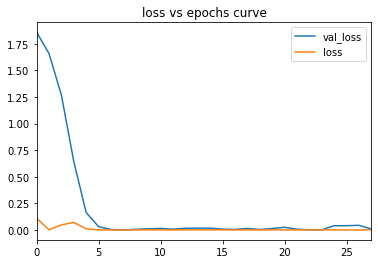

In [20]:
pd.DataFrame(model.history.history).plot(title="loss vs epochs curve")

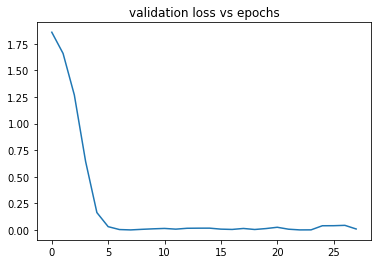

In [21]:
myloss = model.history.history["val_loss"]
plt.title("validation loss vs epochs")
plt.plot(range(len(myloss)),myloss)

Forecast

In [23]:
##Forecast
test_prediction = []

##last n points from training set
first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape(1,n_input,n_features)

In [24]:
for i in range(len(test)+7):
    current_pred = model.predict(current_batch)[0]
    test_prediction.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [25]:
true_prediction = scaler.inverse_transform(test_prediction)
true_prediction[:,0]

array([10648.27077091, 11781.99372768, 13034.96261299, 14430.63486874,
       16025.55108309, 17931.86190367, 20015.41648388, 22484.50400352,
       25467.20163465, 29156.28901482, 33832.84724355, 39906.86636209])

In [26]:
time_series_array = test.index
for k in range(0,7):
    time_series_array = time_series_array.append(time_series_array[-1:] + pd.DateOffset(1))
time_series_array

DatetimeIndex(['2020-04-13', '2020-04-14', '2020-04-15', '2020-04-16',
               '2020-04-17', '2020-04-18', '2020-04-19', '2020-04-20',
               '2020-04-21', '2020-04-22', '2020-04-23', '2020-04-24'],
              dtype='datetime64[ns]', freq=None)

In [27]:
df_forecast = pd.DataFrame(columns=["confirmed","confirmed_predicted"],index=time_series_array)
df_forecast.loc[:,"confirmed_predicted"] = true_prediction[:,0]
df_forecast.loc[:,"confirmed"] = test["confirmed"]
df_forecast

,confirmed,confirmed_predicted
2020-04-13,10453.0,10648.270771
2020-04-14,11487.0,11781.993728
2020-04-15,12322.0,13034.962613
2020-04-16,13430.0,14430.634869
2020-04-17,14352.0,16025.551083
2020-04-18,NaN,17931.861904
2020-04-19,NaN,20015.416484
2020-04-20,NaN,22484.504004
2020-04-21,NaN,25467.201635
2020-04-22,NaN,29156.289015


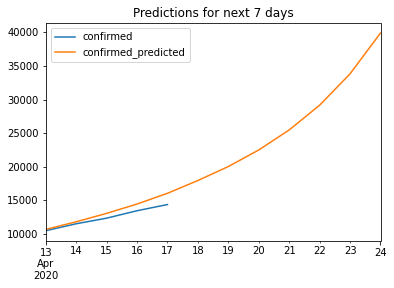

In [28]:
df_forecast.plot(title="Predictions for next 7 days")

In [29]:
MAPE = np.mean(np.abs(np.array(df_forecast["confirmed"][:5]) - np.array(df_forecast["confirmed_predicted"][:5]))/np.array(df_forecast["confirmed"][:5]))
print("MAPE is " + str(MAPE*100) + " %")

MAPE is 5.866747923806879 %


In [30]:
sum_errs = np.sum((np.array(df_forecast["confirmed"][:5]) - np.array(df_forecast["confirmed_predicted"][:5]))**2)
sum_errs

4435511.029105458

In [31]:
stdev = np.sqrt(1/(5-2) * sum_errs)
stdev

1215.9373653147131

In [32]:
interval = 1.96 * stdev
interval

2383.237236016838

In [33]:
df_forecast["confirm_min"] = df_forecast["confirmed_predicted"] - interval
df_forecast["confirm_max"] = df_forecast["confirmed_predicted"] + interval
df_forecast

,confirmed,confirmed_predicted,confirm_min,confirm_max
2020-04-13,10453.0,10648.270771,8265.033535,13031.508007
2020-04-14,11487.0,11781.993728,9398.756492,14165.230964
2020-04-15,12322.0,13034.962613,10651.725377,15418.199849
2020-04-16,13430.0,14430.634869,12047.397633,16813.872105
2020-04-17,14352.0,16025.551083,13642.313847,18408.788319
2020-04-18,NaN,17931.861904,15548.624668,20315.099140
2020-04-19,NaN,20015.416484,17632.179248,22398.653720
2020-04-20,NaN,22484.504004,20101.266768,24867.741240
2020-04-21,NaN,25467.201635,23083.964399,27850.438871
2020-04-22,NaN,29156.289015,26773.051779,31539.526251


In [34]:
df_forecast["Model Accuracy"] = round((1-MAPE),2)
df_forecast

,confirmed,confirmed_predicted,confirm_min,confirm_max,Model Accuracy
2020-04-13,10453.0,10648.270771,8265.033535,13031.508007,0.94
2020-04-14,11487.0,11781.993728,9398.756492,14165.230964,0.94
2020-04-15,12322.0,13034.962613,10651.725377,15418.199849,0.94
2020-04-16,13430.0,14430.634869,12047.397633,16813.872105,0.94
2020-04-17,14352.0,16025.551083,13642.313847,18408.788319,0.94
2020-04-18,NaN,17931.861904,15548.624668,20315.099140,0.94
2020-04-19,NaN,20015.416484,17632.179248,22398.653720,0.94
2020-04-20,NaN,22484.504004,20101.266768,24867.741240,0.94
2020-04-21,NaN,25467.201635,23083.964399,27850.438871,0.94
2020-04-22,NaN,29156.289015,26773.051779,31539.526251,0.94


In [35]:
from datetime import datetime
df_forecast["Country"] = country
df_forecast

,confirmed,confirmed_predicted,confirm_min,confirm_max,Model Accuracy,Country
2020-04-13,10453.0,10648.270771,8265.033535,13031.508007,0.94,India
2020-04-14,11487.0,11781.993728,9398.756492,14165.230964,0.94,India
2020-04-15,12322.0,13034.962613,10651.725377,15418.199849,0.94,India
2020-04-16,13430.0,14430.634869,12047.397633,16813.872105,0.94,India
2020-04-17,14352.0,16025.551083,13642.313847,18408.788319,0.94,India
2020-04-18,NaN,17931.861904,15548.624668,20315.099140,0.94,India
2020-04-19,NaN,20015.416484,17632.179248,22398.653720,0.94,India
2020-04-20,NaN,22484.504004,20101.266768,24867.741240,0.94,India
2020-04-21,NaN,25467.201635,23083.964399,27850.438871,0.94,India
2020-04-22,NaN,29156.289015,26773.051779,31539.526251,0.94,India


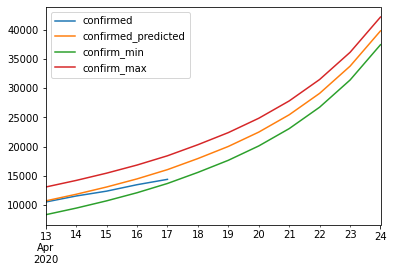

In [36]:
df_forecast.iloc[:,:4].plot()

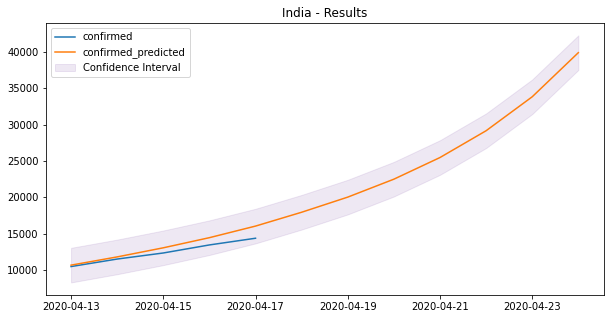

In [37]:
fig= plt.figure(figsize=(10,5))
plt.title("{} - Results".format(country))
plt.plot(df_forecast.index,df_forecast["confirmed"],label="confirmed")
plt.plot(df_forecast.index,df_forecast["confirmed_predicted"],label="confirmed_predicted")
#ax.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)
plt.fill_between(df_forecast.index,df_forecast["confirm_min"],df_forecast["confirm_max"],color="indigo",alpha=0.09,label="Confidence Interval")
plt.legend()
plt.show()